In [1]:
!pip install tensorflow_addons
!pip install keras-tuner --upgrade

# clone siren repository, refresh folder to see the siren repository
# runtime -> change runtime -> choose a gpu/tpu
!git clone https://github.com/hubtru/Siren/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.2 MB/s eta 0:00:00
Cloning into 'Siren'...
remote: Enumerating objects: 351, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 351 (delta 26), reused 48 (delta 22), pack-reused 297
Receiving objects: 100% (351/351), 188.93 MiB | 23.86 MiB/s, done.
Resolving deltas: 100% (98/98), done.
Updating files: 100% (236/236), done.


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras as k
from keras import layers
from sklearn.model_selection import train_test_split
import cv2
import os

os.environ["CUDA_VISIBLE_DEVICES"]="2"

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're u

In [3]:
# ============================== gpu info ==============================
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
print("GPUs: ", tf.config.list_physical_devices("GPU"))

Num GPUs Available:  0
GPUs:  []


In [4]:
# ============================== variables ==============================
image_size = 256
num_classes = 3

in_channel_spec = 9
in_channel_chip = 3
img_rows, img_cols = image_size, image_size
input_shape_spec = (img_rows, img_cols, in_channel_spec)
input_shape_chip = (img_rows, img_cols, in_channel_chip)

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 8
epochs = 100

In [5]:
# ============================== paths ==============================
# needed for generate_data
modality = "multi_sc"
exp_name = f"siren_reg"
sub_exp_name = f"base"
model_name = f"{exp_name}_{sub_exp_name}_{modality}"
model_save_path = f"{model_name}.h5"

model_spec_path = f"/content/Siren/models/regression/{exp_name}_{sub_exp_name}_spec.h5"
model_chip_path = f"/content/Siren/models/regression/{exp_name}_{sub_exp_name}_chip.h5"

# dataset
csv_path = "/content/Siren/dataset/labels_reg_sample.csv"
spec_path = "/content/Siren/dataset/spec"
chip_path = "/content/Siren/dataset/chip"

In [6]:
# ============================== load/prepare dataset ==============================
df = pd.read_csv(csv_path)

# RANDOM DATASET: we switch to toolbased
# shuffle, need same state for tool/spec/chip/multi
np.random.seed(55)
df = df.iloc[np.random.permutation(len(df))]
# train/test/val : 70/15/15
train_df, test_df = train_test_split(df, test_size=0.3)
test_df, val_df = train_test_split(test_df, test_size=0.5)

print(
    "size check train/test/val",
    len(train_df),
    len(test_df),
    len(val_df),
    (len(train_df) + len(test_df) + len(val_df)),
)

train_df["spec_x"] = train_df.id.map(lambda id: f"{spec_path}/x/{id}.jpg")
test_df["spec_x"] = test_df.id.map(lambda id: f"{spec_path}/x/{id}.jpg")
val_df["spec_x"] = val_df.id.map(lambda id: f"{spec_path}/x/{id}.jpg")

train_df["spec_y"] = train_df.id.map(lambda id: f"{spec_path}/y/{id}.jpg")
test_df["spec_y"] = test_df.id.map(lambda id: f"{spec_path}/y/{id}.jpg")
val_df["spec_y"] = val_df.id.map(lambda id: f"{spec_path}/y/{id}.jpg")

train_df["spec_z"] = train_df.id.map(lambda id: f"{spec_path}/z/{id}.jpg")
test_df["spec_z"] = test_df.id.map(lambda id: f"{spec_path}/z/{id}.jpg")
val_df["spec_z"] = val_df.id.map(lambda id: f"{spec_path}/z/{id}.jpg")

train_df["chip"] = train_df.id.map(lambda id: f"{chip_path}/{id}.jpg")
test_df["chip"] = test_df.id.map(lambda id: f"{chip_path}/{id}.jpg")
val_df["chip"] = val_df.id.map(lambda id: f"{chip_path}/{id}.jpg")

size check train/test/val 14 3 3 20


<Figure size 600x600 with 0 Axes>

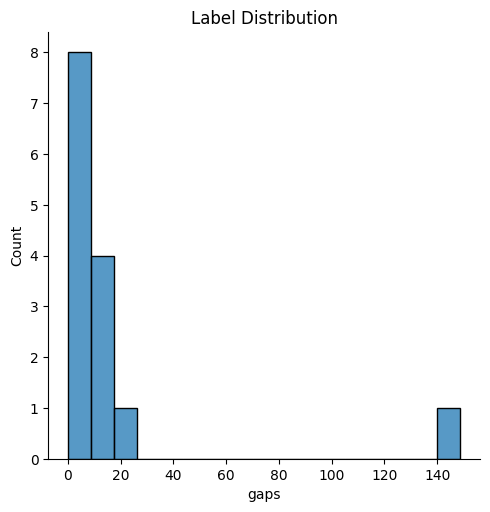

In [7]:
plt.figure(figsize=(6, 6))
sns.displot(train_df["gaps"])
plt.title("Label Distribution")
plt.show()

<Figure size 600x600 with 0 Axes>

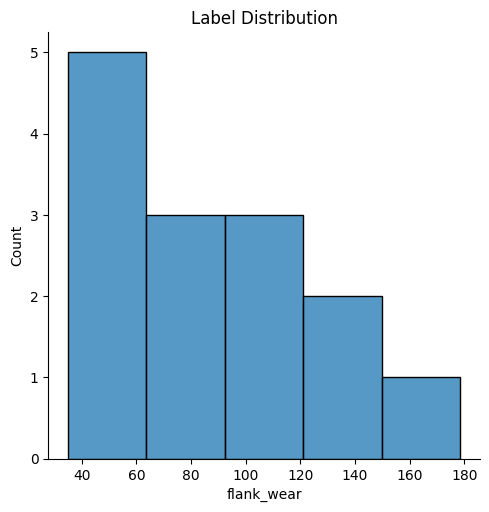

In [8]:
plt.figure(figsize=(6, 6))
sns.displot(train_df["flank_wear"])
plt.title("Label Distribution")
plt.show()

<Figure size 600x600 with 0 Axes>

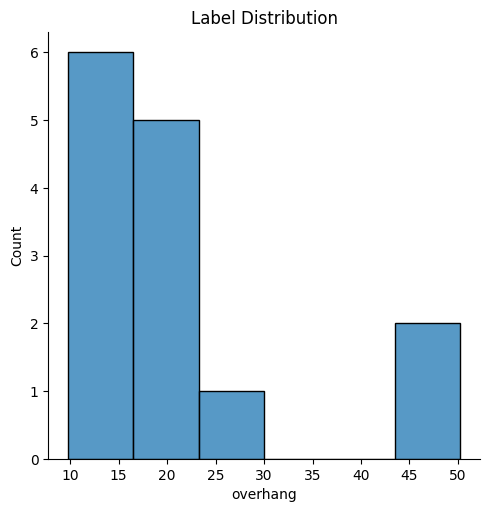

In [9]:
plt.figure(figsize=(6, 6))
sns.displot(train_df["overhang"])
plt.title("Label Distribution")
plt.show()

In [10]:
print("check if permutation is same on all models")
print("train_head", train_df.head())
print("test_head", test_df.head())
print("val_head", val_df.head())

check if permutation is same on all models
train_head          id   gaps  flank_wear  overhang  \
14   T8R3B4   6.88       40.92     14.54   
10   T6R9B3  12.94       95.63     16.65   
0    T1R2B1   7.67       34.89     48.61   
3   T2R13B4   0.00      122.59     25.55   
1    T1R7B4  13.89       85.41     50.25   

                                       spec_x  \
14   /content/Siren/dataset/spec/x/T8R3B4.jpg   
10   /content/Siren/dataset/spec/x/T6R9B3.jpg   
0    /content/Siren/dataset/spec/x/T1R2B1.jpg   
3   /content/Siren/dataset/spec/x/T2R13B4.jpg   
1    /content/Siren/dataset/spec/x/T1R7B4.jpg   

                                       spec_y  \
14   /content/Siren/dataset/spec/y/T8R3B4.jpg   
10   /content/Siren/dataset/spec/y/T6R9B3.jpg   
0    /content/Siren/dataset/spec/y/T1R2B1.jpg   
3   /content/Siren/dataset/spec/y/T2R13B4.jpg   
1    /content/Siren/dataset/spec/y/T1R7B4.jpg   

                                       spec_z  \
14   /content/Siren/dataset/spec/z/T8R3B4.

In [11]:
def read_tools(file_paths, img_rows, img_cols, channels):
    """
    Reads the spectogram files from disk and normalizes the pixel values
      @params:
        file_paths - Array of file paths to read from
        img_rows - The image height.
        img_cols - The image width.
        as_grey - Read the image as Greyscale or RGB.
        channels - Number of channels.
      @returns:
        The created and compiled model (Model)
    """
    images = []

    for file_path in file_paths:
        img = cv2.imread(file_path)
        res = cv2.resize(img, dsize=(img_rows, img_cols), interpolation=cv2.INTER_CUBIC)
        images.append(res)

    images = np.asarray(images, dtype=np.float32)

    # normalize
    images = images / np.max(images)

    # reshape to match Keras expectaions
    images = images.reshape(images.shape[0], img_rows, img_cols, channels)

    return images


def read_specs(file_paths_x, file_paths_y, file_paths_z, img_rows, img_cols, channels):
    """
    Reads the spectogram files from disk and normalizes the pixel values
      @params:
        file_paths - Array of file paths to read from
        img_rows - The image height.
        img_cols - The image width.
        as_grey - Read the image as Greyscale or RGB.
        channels - Number of channels.
      @returns:
        The created and compiled model (Model)
    """
    images = []
    for i in range(file_paths_x.size):
        img = []
        img_x = cv2.imread(file_paths_x[i])
        res_x = cv2.resize(
            img_x, dsize=(img_rows, img_cols), interpolation=cv2.INTER_CUBIC
        )
        img.append(res_x)

        img_y = cv2.imread(file_paths_y[i])
        res_y = cv2.resize(
            img_y, dsize=(img_rows, img_cols), interpolation=cv2.INTER_CUBIC
        )
        img.append(res_y)

        img_z = cv2.imread(file_paths_z[i])
        res_z = cv2.resize(
            img_z, dsize=(img_rows, img_cols), interpolation=cv2.INTER_CUBIC
        )
        img.append(res_z)
        img = np.concatenate(img, axis=2)
        images.append(img)

    images = np.asarray(images, dtype=np.float32)

    # normalize
    images = images / 255.0

    return images

In [12]:
x_train_spec = read_specs(
    train_df.spec_x.values,
    train_df.spec_y.values,
    train_df.spec_z.values,
    img_rows,
    img_cols,
    in_channel_spec,
)
x_test_spec = read_specs(
    test_df.spec_x.values,
    test_df.spec_y.values,
    test_df.spec_z.values,
    img_rows,
    img_cols,
    in_channel_spec,
)
x_val_spec = read_specs(
    val_df.spec_x.values,
    val_df.spec_y.values,
    val_df.spec_z.values,
    img_rows,
    img_cols,
    in_channel_spec,
)

x_train_chip = read_tools(train_df.chip.values, img_rows, img_cols, in_channel_chip)
x_test_chip = read_tools(test_df.chip.values, img_rows, img_cols, in_channel_chip)
x_val_chip = read_tools(val_df.chip.values, img_rows, img_cols, in_channel_chip)

In [13]:
x_train_spec.shape

(14, 256, 256, 9)

In [14]:
x_train_chip.shape

(14, 256, 256, 3)

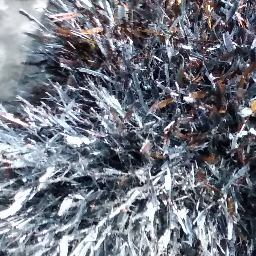

In [15]:
pil_img = tf.keras.utils.array_to_img(x_train_chip[0])
pil_img

[]

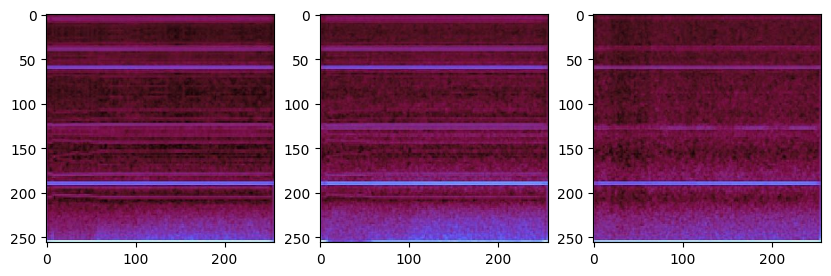

In [16]:
# Split the last dimension into 3 separate spectrograms
spectrogram1 = x_train_spec[0, :, :, 0:3]  # First spectrogram (channels 0-2)
spectrogram2 = x_train_spec[0, :, :, 3:6]  # Second spectrogram (channels 3-5)
spectrogram3 = x_train_spec[0, :, :, 6:9]  # Third spectrogram (channels 6-8)
# Convert arrays to images
pil_img1 = tf.keras.utils.array_to_img(spectrogram1)
pil_img2 = tf.keras.utils.array_to_img(spectrogram2)
pil_img3 = tf.keras.utils.array_to_img(spectrogram3)
# Display the images
fig, ax = plt.subplots(1,3, figsize=(10,30))
ax[0].imshow(pil_img1)
ax[1].imshow(pil_img2)
ax[2].imshow(pil_img3)
plt.plot()

In [17]:
labels_train = train_df[["gaps", "flank_wear", "overhang"]]
labels_test = test_df[["gaps", "flank_wear", "overhang"]]
labels_val = val_df[["gaps", "flank_wear", "overhang"]]

In [18]:
# ============================== augment 1/2 ==============================
data_augmentation_spec = k.Sequential(
    [
        k.layers.RandomBrightness(factor=(-0.2, 0.2), value_range=(0, 1)),
        k.layers.RandomContrast(factor=0.2),
        k.layers.GaussianNoise(stddev=0.2),
    ],
    name="data_augmentation_spec",
)

In [19]:
# ============================== augment 2/2 ==============================
data_augmentation_chip = k.Sequential(
    [
        k.layers.RandomBrightness(factor=(-0.2, 0.2), value_range=(0, 1)),
        k.layers.RandomContrast(factor=0.2),
        k.layers.GaussianNoise(stddev=0.2),
    ],
    name="data_augmentation_chip",
)

In [20]:
x_train_spec = data_augmentation_spec(x_train_spec)
x_train_chip = data_augmentation_chip(x_train_chip)

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {
            "input_1_spec": x_train_spec,
            "input_1_chip": x_train_chip,
        },
        labels_train,
    )
)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {
            "input_1_spec": x_test_spec,
            "input_1_chip": x_test_chip,
        },
        labels_test,
    )
)
val_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {
            "input_1_spec": x_val_spec,
            "input_1_chip": x_val_chip,
        },
        labels_val,
    )
)

In [22]:
auto = tf.data.AUTOTUNE
inputs2 = k.Input(input_shape_spec)
inputs3 = k.Input(input_shape_chip)

In [23]:
def generate_datasets(images, is_train=False, shuffle=False):
    dataset = images
    if shuffle:
        dataset = dataset.shuffle(batch_size * 10)
    dataset = dataset.batch(batch_size)
    if is_train:
        pass
    return dataset.prefetch(auto)

In [24]:
train_ds = generate_datasets(train_dataset, is_train=True, shuffle=True)
val_ds = generate_datasets(val_dataset)
test_ds = generate_datasets(test_dataset)

In [25]:
train_ds

<_PrefetchDataset element_spec=({'input_1_spec': TensorSpec(shape=(None, 256, 256, 9), dtype=tf.float32, name=None), 'input_1_chip': TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)}, TensorSpec(shape=(None, 3), dtype=tf.float64, name=None))>

In [26]:
model_spec = k.models.load_model(model_spec_path, compile=False)
model_chip = k.models.load_model(model_chip_path, compile=False)

model_spec.trainable = False
model_chip.trainable = False


def load_siren(model_spec, model_chip):
    inputs2 = model_spec.input
    inputs2._name = "input_spec"
    inputs3 = model_chip.input
    inputs3._name = "input_chip"

    truncated_model_spec = k.Model(
        inputs=model_spec.input, outputs=model_spec.layers[-2].output
    )
    truncated_model_chip = k.Model(
        inputs=model_chip.input, outputs=model_chip.layers[-2].output
    )
    mergedOut = k.layers.Concatenate()(
        [
            truncated_model_spec.output,
            truncated_model_chip.output,
        ]
    )
    output = layers.Dense(num_classes, activation="linear", name="output_mult")(
        mergedOut
    )
    return k.Model(inputs=[inputs2, inputs3], outputs=output)


for layer in model_spec.layers:
    layer._name = layer.name + str("_spec")
for layer in model_chip.layers:
    layer._name = layer.name + str("_chip")

In [27]:
def launch_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer, loss="mse", metrics=[tf.keras.metrics.MeanSquaredError()]
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
    )

    _, accuracy = model.evaluate(test_ds)
    print(f"Test error: {round(accuracy, 2)}")

    return history, model

In [28]:
model = load_siren(model_spec, model_chip)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1_spec (InputLayer)      [(None, 256, 256, 9  0           []                               
                                )]                                                                
                                                                                                  
 input_1_chip (InputLayer)      [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_spec (Conv2D)           (None, 16, 16, 256)  590080      ['input_1_spec[0][0]']           
                                                                                            

In [29]:
history, model = launch_experiment(model)

Epoch 1/100
2/2 [==============================] - 31s 4s/step - loss: 3881.7222 - mean_squared_error: 3881.7222 - val_loss: 4780.3149 - val_mean_squared_error: 4780.3149
Epoch 2/100
2/2 [==============================] - 1s 697ms/step - loss: 3774.8962 - mean_squared_error: 3774.8965 - val_loss: 4672.6606 - val_mean_squared_error: 4672.6606
Epoch 3/100
2/2 [==============================] - 1s 720ms/step - loss: 3676.7271 - mean_squared_error: 3676.7271 - val_loss: 4568.3374 - val_mean_squared_error: 4568.3374
Epoch 4/100
2/2 [==============================] - 1s 605ms/step - loss: 3581.6868 - mean_squared_error: 3581.6868 - val_loss: 4466.6719 - val_mean_squared_error: 4466.6719
Epoch 5/100
2/2 [==============================] - 1s 729ms/step - loss: 3500.1699 - mean_squared_error: 3500.1699 - val_loss: 4367.2388 - val_mean_squared_error: 4367.2388
Epoch 6/100
2/2 [==============================] - 1s 623ms/step - loss: 3401.0916 - mean_squared_error: 3401.0916 - val_loss: 4270.1763 

In [30]:
model.save(model_save_path)

In [31]:
pred = model.predict(test_ds)

1/1 [==============================] - 3s 3s/step


In [32]:
# ============================== generate data ==============================
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import PredictionErrorDisplay
from sklearn import metrics
import tensorflow as tf
from tensorflow import keras as k

In [33]:
multi_pred = pred
gaps_pred, flank_wear_pred, overhang_pred = multi_pred.T

multi_true = labels_test.to_numpy()
gaps_true, flank_wear_true, overhang_true = multi_true.T

In [34]:
labels_list = [
    "gaps",
    "flank_wear",
    "overhang",
    "multi",
]
pred_list = [
    gaps_pred,
    flank_wear_pred,
    overhang_pred,
    multi_pred,
]
true_list = [
    gaps_true,
    flank_wear_true,
    overhang_true,
    multi_true,
]

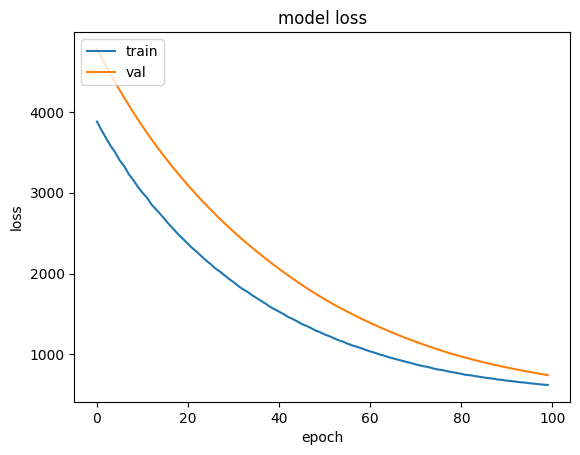

In [35]:
# loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

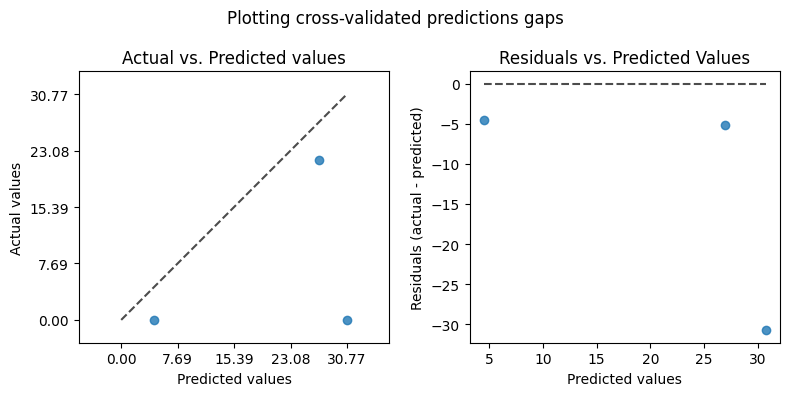

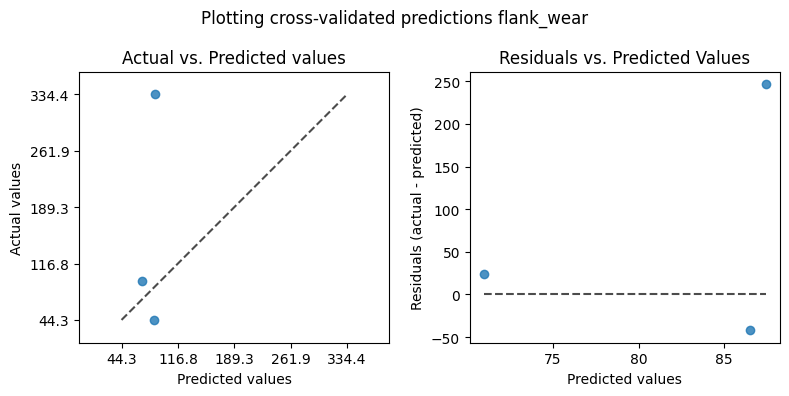

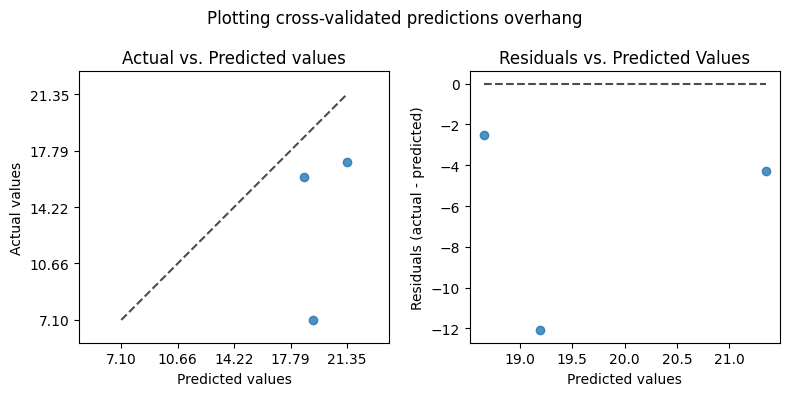

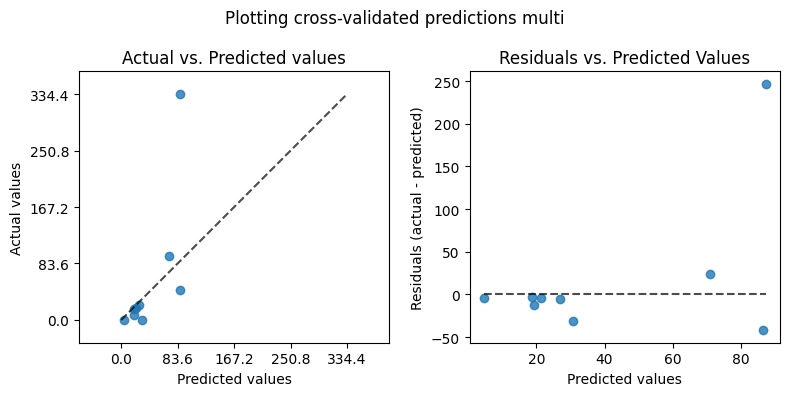

In [36]:
for label, y_pred, y_true in zip(labels_list, pred_list, true_list):
    # https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_predict.html#sphx-glr-auto-examples-model-selection-plot-cv-predict-py
    fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
    PredictionErrorDisplay.from_predictions(
        y_true=y_true,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        subsample=100,
        ax=axs[0],
        random_state=0,
    )
    axs[0].set_title("Actual vs. Predicted values")
    PredictionErrorDisplay.from_predictions(
        y_true=y_true,
        y_pred=y_pred,
        kind="residual_vs_predicted",
        subsample=100,
        ax=axs[1],
        random_state=0,
    )
    axs[1].set_title("Residuals vs. Predicted Values")
    fig.suptitle("Plotting cross-validated predictions " + label)
    plt.tight_layout()
    plt.show()

In [37]:
def min_shift(list1, list2):
    list1 = np.array(list1)
    list2 = np.array(list2)
    if list1.ndim == 2:
        for i in range(len(list1)):
            if np.min([list1, list2]) > 0:
                continue
            min = np.min([list1[i], list2[i]])
            list1[i] -= min
            list2[i] -= min
        return list1, list2

    min = np.min([list1, list2])
    list1 = list1 - min
    list2 = list1 - min

    return list1, list2

In [38]:
for label, y_pred, y_true in zip(labels_list, pred_list, true_list):
    print(f"===== {label} results =====")
    print("MAE: ", metrics.mean_absolute_error(y_true, y_pred))
    print("MSE: ", metrics.mean_squared_error(y_true, y_pred))
    print("RMSE: ", metrics.mean_squared_error(y_true, y_pred, squared=False))
    print("r2_score: ", metrics.r2_score(y_true, y_pred))
    try:
        print("MSLE: ", metrics.mean_squared_log_error(y_true, y_pred))
    except ValueError as err:
        y_true_shift, y_pred_shift = min_shift(y_true, y_pred)
        print(
            "MSLE_min_shifted: ",
            metrics.mean_squared_log_error(y_true_shift, y_pred_shift),
        )
    print("MAPE: ", metrics.mean_absolute_percentage_error(y_true, y_pred))

===== gaps results =====
MAE:  13.472395248413086
MSE:  331.2333586592861
RMSE:  18.199817544670225
r2_score:  -2.139294951258398
MSLE:  4.9661337533912215
MAPE:  5.29237352092358e+16
===== flank_wear results =====
MAE:  104.27626291910808
MSE:  21110.286003043733
RMSE:  145.2937920320195
r2_score:  -0.31755196779170203
MSLE:  0.7640359397160951
MAPE:  0.6474790645977769
===== overhang results =====
MAE:  6.302940673828125
MSE:  57.020516437866924
RMSE:  7.551193047318213
r2_score:  -1.826650670940932
MSLE:  0.299618764292413
MAPE:  0.7037746327147287
===== multi results =====
MAE:  41.35053294711643
MSE:  7166.179959380296
RMSE:  57.01493420800264
r2_score:  -1.4278325299970105
MSLE:  2.0099294857999097
MAPE:  1.7641245069745266e+16
